In [498]:
import pandas as pd
import numpy as np
import random as rd
import os
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

In [499]:
df = pd.read_csv("ckextended.csv")
df.head()

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


In [500]:
emotions = ['Anger', "Disgust", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]  # Emoções do CK+ (Ordenadas)
data_path = "ckextended.csv" 
emotion_data = {}
emotion_pcas = {}

In [501]:
df.value_counts("emotion")    

emotion
6    593
5     83
3     69
1     59
0     45
4     28
2     25
7     18
Name: count, dtype: int64

In [502]:
df = df[df["emotion"] != 7]

**FUNÇÕES IMPORTANTES**

**Inicialmente tentei fazer com reconstrução de espaço vetorial com PCA e projeção da imagem-alvo.**

* **A função *training_PCA* é reponsável por:**

In [519]:
def training_PCA(faces_flatten, df_flatten, target_index):
    emotion_data = {}
    emotion_pcas = {}
    
    target_img = faces_flatten[target_index] / 255.0  # Normalização simples
        
    for emotion in emotions:
        data = df_flatten[df_flatten["emotion"] == emotion]["pixels"]
        
        if data.shape[0] == 0:
            continue
        
        X_train = np.vstack(data).astype(np.float32) / 255.0  # Normalização simples
        emotion_indices = data.index.values
        target_row = target_index
        
        if target_row in emotion_indices:
            data = data.drop(target_row)      # Evita overfitting. (Exclui a própria imagem-alvo do treinamento)
        
        X_train = np.vstack(data.values).astype(np.float32) / 255.0  # Normalização simples
        
        if emotion == "Neutral":
            size_train = 30
        else: 
            size_train = len(X_train) 
        
        X_train = X_train[0:size_train]   # Restringe e quantidade de treino de Neutral a fins de precisão
        size_train = len(X_train)
        emotion_data[emotion] = {'train': X_train}
        #print("Treinando", emotion, "com shape:", X_train.shape)
        
        if X_train.shape[0] < 2:
            print("Amostras insuficientes, pulando", emotion)
            continue
        
        pca = PCA(n_components= size_train).fit(X_train)
        emotion_pcas[emotion] = pca
        
    return emotion_data, emotion_pcas


* **A função *classify_emotion* é responsável por:**

In [506]:
def classify_emotion(faces_flatten, emotion_pcas, target_index):
    min_error = float('inf')
    predicted_emotion = None
    target_image = faces_flatten[target_index] / 255.0
    all_errors = {}
    # Projetar a imagem-alvo em cada PCA gerado pelo X_Train de um emoção específica
    for emotion, pca in emotion_pcas.items():
        
        # Projetamos a imagem alvo no espaço gerado pelo PCA daquela emoção
        projection = pca.transform([target_image])

        # Reconstruir a imagem usando aquela fórmula A1 = B @ C.T
        reconstruction = pca.inverse_transform(projection).flatten()      

        # Calcula erro 
        error = np.linalg.norm(target_image - reconstruction) / np.linalg.norm(target_image)

        all_errors[emotion] = error
        if error < min_error:
            min_error = error
            predicted_emotion = emotion

    return predicted_emotion, min_error, all_errors

**Como não houve uma precisão satisfatória usando apenas PCA, pesquisei novas formas de identificar padrões das imagens e reconhecer emoções usando PCA**.

**Optei por usar uma rede neural simples: *Logistic Regression*.**

* **A função *training_PCA_LR* é responsável por:**

In [503]:
def training_PCA_LR(faces_flatten, df_flatten, n_components=80):
    """
    Treina PCA global + Logistic Regression.
    faces_flatten: array [N, D] com imagens flatten
    df_flatten: dataframe com coluna "emotion"
    """
    # Normaliza
    X = np.vstack(faces_flatten).astype(np.float32) / 255.0
    y = df_flatten["emotion"].values

    # Treina PCA global
    pca = PCA(n_components=n_components, svd_solver="randomized")
    X_proj = pca.fit_transform(X)

    # Treina Logistic Regression no espaço PCA
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_proj, y)

    return pca, clf

* **A função *classify_emotion_PCA_LR* é responsável por:**

In [504]:
def classify_emotion_PCA_LR(faces_flatten, pca, clf, target_index):
    """
    Classifica uma imagem usando PCA + Logistic Regression.
    """
    # Normaliza a imagem-alvo
    target = faces_flatten[target_index].astype(np.float32) / 255.0
    
    # Projeta no espaço PCA
    target_proj = pca.transform([target])

    # Predição via logistic regression
    predicted_emotion = clf.predict(target_proj)[0]

    # Probabilidades (softmax)
    probs = clf.predict_proba(target_proj)[0]

    return predicted_emotion, probs

In [507]:
def process_pixels(pixel_str):
    try:
        pixels = np.array(pixel_str.split(), dtype=np.uint8)
        if len(pixels) == 2304:  # Verifica tamanho exato
            return pixels.reshape(2304,-1) # deixa imagens em flatten
        else:
            return None  # Marca como inválido
    except (ValueError, TypeError):
        return None  # Trata erros (e.g., string vazia)

**LIMPEZA E NORMALIZAÇÃO**

In [508]:
df["emotion"] = df["emotion"].replace({
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral"
}).astype(str)

df = df.sort_values(by="emotion").reset_index(drop=True)

In [509]:
df_flatten = df.copy()
df_flatten["pixels"] = df["pixels"].apply(lambda x: process_pixels(x).flatten())
df_flatten["pixels"][0]  # Imagens estão em vetores verticais ;)

array([ 50,  51,  38, ..., 254, 133, 101], shape=(2304,), dtype=uint8)

In [510]:
df_flatten["emotion"] = df_flatten["emotion"].replace({
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sadness",
    5: "Surprise",
    6: "Neutral"
}).astype(str)

df_flatten["emotion"] = df_flatten["emotion"].astype(str)

In [511]:
faces = df["pixels"].apply(lambda x: process_pixels(x).reshape(48, 48))
faces_flatten = df["pixels"].apply(lambda x: process_pixels(x).flatten())

In [526]:
lengths = df.groupby("emotion").size().to_list()
begin = df.groupby("emotion").head(1).index.to_list()

begin.append(901)
begin, lengths

([0, 45, 104, 129, 198, 791, 819, 901], [45, 59, 25, 69, 593, 28, 83])

**Aqui fiz uma substituição dos indexes que indicavam emoções por string que facilitam a visualização**

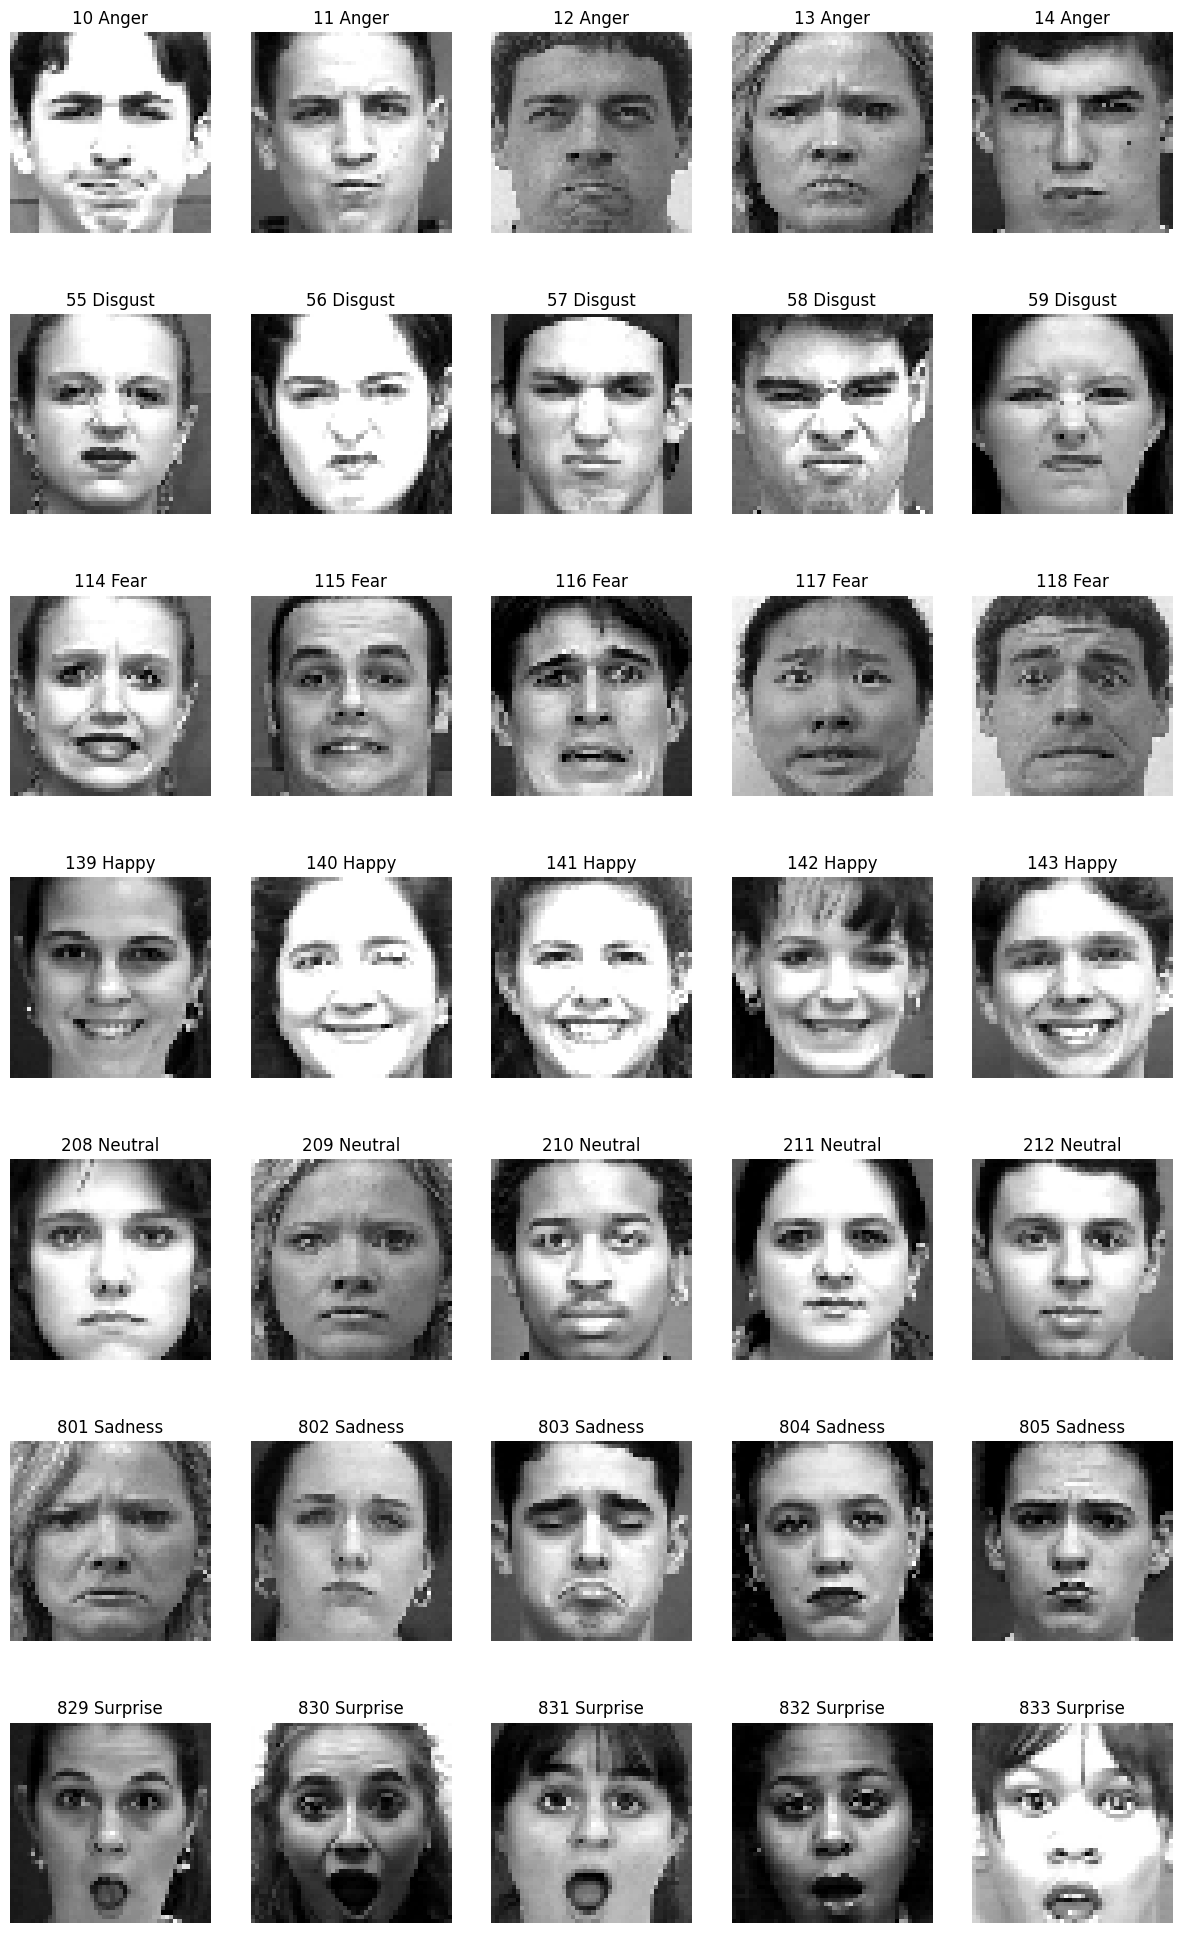

In [533]:
plt.figure(figsize=(15, 25))
k = 10
for i in range(7):
    for j in range(5):
        img = faces[begin[i] + j + k]
        expression  = df_flatten.loc[begin[i] + j + k]["emotion"]        
        idx = i*5 + j + 1
        plt.subplot(7, 5, idx) 
        plt.imshow(img, cmap="gray")
        plt.title(f"{begin[i] + j + k} {expression}", fontsize=12)
        plt.axis("off")
plt.show()

In [527]:
for i in range(7):
    print(f"{begin[i]:>3}   ->  {(begin[i+1]-1):>3}  =  {emotions[i]}")

  0   ->   44  =  Anger
 45   ->  103  =  Disgust
104   ->  128  =  Fear
129   ->  197  =  Happy
198   ->  790  =  Neutral
791   ->  818  =  Sadness
819   ->  900  =  Surprise


**Usando o método de Reconstrução A1 = B * C.T**

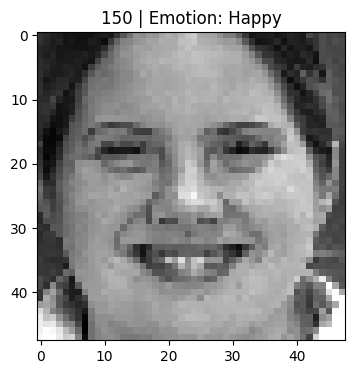

In [535]:
target_index = 150

# IMAGEM ORIGINAL
face = faces[target_index]
emotion = df_flatten.loc[target_index]["emotion"]
plt.figure(figsize=(4, 4))
plt.title(f"{target_index} | Emotion: {emotion}")
plt.imshow(face, cmap='gray')
#plt.axis("off")
plt.show()

In [536]:
data, pcas = training_PCA(faces_flatten, df_flatten, target_index)
detected_emotion, min_error, all_errors = classify_emotion(faces_flatten, pcas, target_index)

print(f"\nEmoção detectada: {detected_emotion} | Erro: {min_error:.4f}\n\nTodos os erros:")
for emotion, error in all_errors.items():
    print(f"Emoção: {emotion:>10} -> Erro: {(error):.4f}")



Emoção detectada: Anger | Erro: 0.1741

Todos os erros:
Emoção:      Anger -> Erro: 0.1741
Emoção:    Disgust -> Erro: 0.1906
Emoção:       Fear -> Erro: 0.2547
Emoção:      Happy -> Erro: 0.2191
Emoção:    Neutral -> Erro: 0.2559
Emoção:    Sadness -> Erro: 0.2517
Emoção:   Surprise -> Erro: 0.2105


**Usando método PCA + Logistic Regression**

In [537]:
pca_global, clf = training_PCA_LR(faces_flatten, df_flatten)
detected_emotion, probs = classify_emotion_PCA_LR(faces_flatten, pca_global, clf, target_index)

print(f"\nEmoção detectada: {detected_emotion}")
for i in range(7):
    print(f"Emoção: {emotions[i]:>10} -> Probabilidade: {(probs[i]*100):.3f} %")


Emoção detectada: Happy
Emoção:      Anger -> Probabilidade: 2.507 %
Emoção:    Disgust -> Probabilidade: 1.685 %
Emoção:       Fear -> Probabilidade: 0.091 %
Emoção:      Happy -> Probabilidade: 95.516 %
Emoção:    Neutral -> Probabilidade: 0.099 %
Emoção:    Sadness -> Probabilidade: 0.001 %
Emoção:   Surprise -> Probabilidade: 0.102 %


**Testando todos os casos com PCA + Reconstrução A1 = B * C.T**

In [538]:
green = 0
red = 0
e_green = 0
e_red = 0
neutrals = 0
for b in range(7):
    print(f"Emotion:  {emotions[b]}")
    e_green = 0
    e_red = 0
    c = 0
    for i in range(begin[b], begin[b+1]):
        data, pcas = training_PCA(faces_flatten, df_flatten, i)
        detected_emotion, min_error, all_errors = classify_emotion(faces_flatten, pcas, i)
        if(detected_emotion == df_flatten.loc[i]["emotion"]):
            e_green += 1
        else: 
            e_red += 1
            if detected_emotion == "Neutral":
                neutrals += 1
        c += 1
    print(f"Casos avaliados: {c} | Acertos : {e_green} | Erros: {e_red} | Acc : {e_green/c:.3f} | Erros pra neutral: {neutrals}\n")
    green += e_green
    red += e_red

print(f"Acertos Totais : {green} | Erros Totais: {red}")


Emotion:  Anger
Casos avaliados: 45 | Acertos : 5 | Erros: 40 | Acc : 0.111 | Erros pra neutral: 6

Emotion:  Disgust
Casos avaliados: 59 | Acertos : 22 | Erros: 37 | Acc : 0.373 | Erros pra neutral: 11

Emotion:  Fear
Casos avaliados: 25 | Acertos : 0 | Erros: 25 | Acc : 0.000 | Erros pra neutral: 12

Emotion:  Happy
Casos avaliados: 69 | Acertos : 50 | Erros: 19 | Acc : 0.725 | Erros pra neutral: 13

Emotion:  Neutral
Casos avaliados: 593 | Acertos : 104 | Erros: 489 | Acc : 0.175 | Erros pra neutral: 13

Emotion:  Sadness
Casos avaliados: 28 | Acertos : 0 | Erros: 28 | Acc : 0.000 | Erros pra neutral: 21

Emotion:  Surprise
Casos avaliados: 82 | Acertos : 75 | Erros: 7 | Acc : 0.915 | Erros pra neutral: 23

Acertos Totais : 256 | Erros Totais: 645


**Testando todos os casos com PCA + Logistic Regression**

In [ ]:
green = 0
red = 0
e_green = 0
e_red = 0
neutrals = 0

pca_global, clf = training_PCA_LR(faces_flatten, df_flatten)

for b in range(7):
    print(f"Emotion:  {emotions[b]}")
    e_green = 0
    e_red = 0
    c = 0
    for i in range(begin[b], begin[b+1]):
        detected_emotion, probs = classify_emotion_PCA_LR(faces_flatten, pca_global, clf, i)
        if(detected_emotion == df_flatten.loc[i]["emotion"]):
            e_green += 1
        else: 
            e_red += 1
            if detected_emotion == "Neutral":
                neutrals += 1
        c += 1
    print(f"Casos avaliados: {c} | Acertos : {e_green} | Erros: {e_red} | Acc : {e_green/c*100:.2f} % | Erros pra neutral: {neutrals}\n")
    green += e_green
    red += e_red

print(f"Acertos Totais : {green} | Erros Totais: {red}")

Emotion:  Anger
Casos avaliados: 45 | Acertos : 39 | Erros: 6 | Acc : 86.67 % | Erros pra neutral: 6

Emotion:  Disgust
Casos avaliados: 59 | Acertos : 56 | Erros: 3 | Acc : 94.92 % | Erros pra neutral: 9

Emotion:  Fear
Casos avaliados: 25 | Acertos : 24 | Erros: 1 | Acc : 96.00 % | Erros pra neutral: 10

Emotion:  Happy
Casos avaliados: 69 | Acertos : 69 | Erros: 0 | Acc : 100.00 % | Erros pra neutral: 10

Emotion:  Neutral
Casos avaliados: 593 | Acertos : 593 | Erros: 0 | Acc : 100.00 % | Erros pra neutral: 10

Emotion:  Sadness
Casos avaliados: 28 | Acertos : 22 | Erros: 6 | Acc : 78.57 % | Erros pra neutral: 16

Emotion:  Surprise
Casos avaliados: 82 | Acertos : 81 | Erros: 1 | Acc : 98.78 % | Erros pra neutral: 17

Acertos Totais : 884 | Erros Totais: 17
